<center><h1>Supplemental Material</h1></center>

<br>
<center><h2>Simple and accurate nonlinear pendulum motion for the full range of amplitudes</h2></center>

Teepanis Chachiyo <teepanisc@nu.ac.th>
Department of Physics, Faculty of Science, Naresuan University, Phitsanulok 65000, Thailand.


### Available at a GitHub repository: [https://github.com/teepanis/nonlinear-pendulum](https://github.com/teepanis/nonlinear-pendulum)


This python notebook tests the performance of the proposed analytical form in conparison to frequenctly cited simple formulae in the literature. The proposed pendulum period is of the form:

$$T(\theta_0) = 2 \pi \sqrt{L/g} \times \frac{2}{n \pi} \ln[\big(\frac{4}{\cos \frac{\theta_0}{2}}\big)^n + b]\tag{S1}$$

where the constans  $ n  = \frac{\ln 4 -  \ln \pi}{\pi/2 -  \ln 4}$ and $b  = e^{n\pi/2} - 4^n$.

## Exact Solution of the Period: $2 \pi \sqrt{L/g} \times \frac{2}{\pi}K(x)$

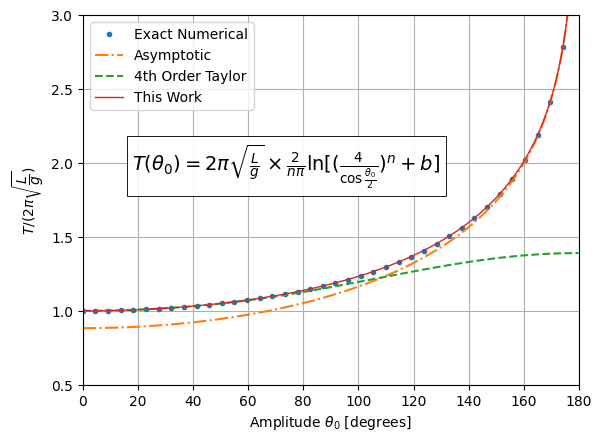

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

# allocate amplitude theta0 and x
theta0 = np.arange(0,np.pi,.004)
x = np.sin(theta0/2)
N = len(x)

# compute exact K(x)
# Notes: scipy defines the arguments of elliptic function 
# differently, so that the x**2 is used instead of just x.
K = scipy.special.ellipk(x**2)

# allocate array for comparisons
K_asym = np.zeros(N)
K_t4 = np.zeros(N)
K_ThisWork = np.zeros(N)
K_lima2008 = np.zeros(N)
K_ganley1985 = np.zeros(N)

for i in range(N):
    
    # (Lima 2008)
    if x[i] > 0.0:
        a = np.sqrt(1-x[i]**2)
        K_lima2008[i] = np.pi/2*( a**2/(1-a)*np.log(1/a) +  2*x[i]**2/np.pi*np.log(4/a)   )
    else:
        K_lima2008[i] = np.pi/2
    
    K_asym[i] = np.log(4/np.sqrt(1-x[i]**2))
    K_t4[i] = np.pi/2*(1 + 1/4*x[i]**2 + ((1*3)/(2*4))**2*x[i]**4 )
    
    # (Ganley 1985)
    alpha = np.sqrt(3)/2*theta0[i]
    if alpha > 0.0: K_ganley1985[i] = np.pi/2*np.sqrt(alpha/np.sin(alpha))
    else: K_ganley1985[i] = 1.0

    n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    b = np.exp(n*np.pi/2) - 4**n
    K_ThisWork[i] = 1/n*np.log( (4/np.sqrt(1-x[i]**2))**n + b)

plt.plot(theta0*180/np.pi, K*2/np.pi,'.',markevery=20, label='Exact Numerical')
plt.plot(theta0*180/np.pi, K_asym*2/np.pi,'-.', label='Asymptotic')
plt.plot(theta0*180/np.pi, K_t4*2/np.pi,'--', label='4th Order Taylor')
plt.plot(theta0*180/np.pi, K_ThisWork*2/np.pi, linewidth=1,label='This Work')

plt.text(18,1.95,'$T(\\theta_0) = 2\\pi\\sqrt{\\frac{L}{g}} \\times \\frac{2}{n \\pi} '
         '\\ln [   (\\frac{4}{\\cos \\frac{\\theta_0}{2}})^n + b ]$', fontsize=14, \
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.7))

#plt.title('The Period of a Pendulum')
plt.xlabel('Amplitude $\\theta_0 $ [degrees]')
plt.ylabel('$T/( 2\\pi\\sqrt{\\dfrac{L}{g}} )$')
plt.ylim([.5,3])
plt.xlim([0,180])
plt.legend()
plt.grid()
#plt.savefig('fig1.pdf')
plt.show()

## Comparisons to Existing Analytical Forms

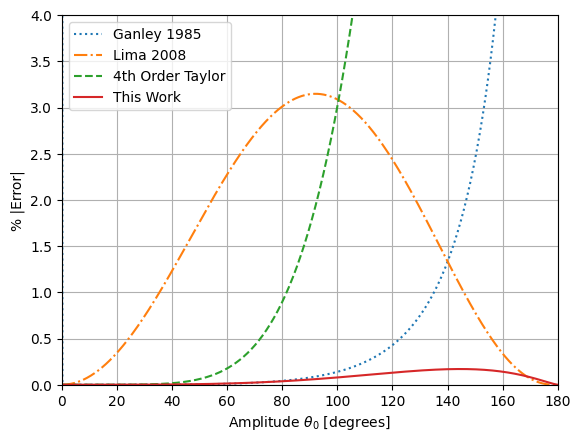

Maximum % |Error|
Lima 2008: 3.15
This Work: 0.17

Average % |Error|
Lima 2008: 1.56
This Work: 0.06


In [7]:
#
# Error comparison
#

plt.plot(theta0*180/np.pi, np.abs(K_ganley1985-K)*100./K,':', label='Ganley 1985')
plt.plot(theta0*180/np.pi, np.abs(K_lima2008-K)*100./K,'-.', label='Lima 2008')
plt.plot(theta0*180/np.pi, np.abs(K_t4-K)*100./K,'--', label='4th Order Taylor')
plt.plot(theta0*180/np.pi, np.abs(K_ThisWork-K)*100./K, label='This Work')

#plt.title('Error compared to the exact K(x)')
plt.xlabel('Amplitude $\\theta_0 $ [degrees]')
plt.ylabel('% |Error|')
plt.xlim([0,180])
plt.ylim(0,4)
plt.legend()
plt.grid()
plt.show()
#plt.savefig('fig2.pdf')

print('Maximum % |Error|')
print('Lima 2008: %.2f' % ( max(np.abs(K_lima2008-K)*100./K) ) )
print('This Work: %.2f' % ( max(np.abs(K_ThisWork-K)*100./K) ) )

print('\nAverage % |Error|')
print('Lima 2008: %.2f' % ( np.average(np.abs(K_lima2008-K)*100./K) ) )
print('This Work: %.2f' % ( np.average(np.abs(K_ThisWork-K)*100./K) ) )

## Derivation of the Constant $n$ and $b$ in Eq. (4)

Below is a python code that symbollically derivatives of the proposed form, evaluated at $x = 0$. The derivatives can then be compared to that of the exact $K(x)$. Demanding that they agree upto the 2nd order will ensure that the proposed form approaches the exact limit when the amplitudes is small.

In [8]:
## checking taylor expansion of the proposed form
##
import sympy as sym

xx = sym.symbols('x', real=True)
bb = sym.symbols('b', real=True)
nn = sym.symbols('n', real=True)

# the proposed form
K0 = 1/nn*sym.ln((4/sym.sqrt(1-xx**2))**nn + bb)

print('0th Derivative: ', K0.subs(xx,0))
K1 = K0.diff(xx)
print('1st Derivative: ', K1.subs(xx,0))
K2 = K1.diff(xx)
print('2nd Derivative: ', K2.subs(xx,0))
K3 = K2.diff(xx)
print('3rd Derivative: ', K3.subs(xx,0))

0th Derivative:  log(4**n + b)/n
1st Derivative:  0
2nd Derivative:  4**n/(4**n + b)
3rd Derivative:  0


Taylor series (sometimes called power series) of the exact $K(x)$ is

$$K(x) = \frac{\pi}{2}[1 + (\frac{1}{2})^2 x^2 + (\frac{1\cdot3}{2\cdot4})^2 x^4 + (\frac{1\cdot3\cdot5}{2\cdot4\cdot6})^2 x^6 + \cdots]\tag{S2}$$

Therefore, $K(0) = \frac{\pi}{2}$ and $K''(0) = \frac{\pi}{4}$. From the output of the python code above, it follows that

$$\begin{align} \frac{1}{n}\log(4^n+b) = \frac{\pi}{2} & \tag{S3} && \\ \frac{4^n}{4^n+b} = \frac{\pi}{4}  & \tag{S4} && \end{align}$$

which lead to

$$ n  = \frac{\ln 4 -  \ln \pi}{\pi/2 -  \ln 4} \quad \text{and} \quad  b  = e^{n\pi/2} - 4^n$$

## Angular Displacement $\theta(t)$

T [sec] =  33.72109737398663


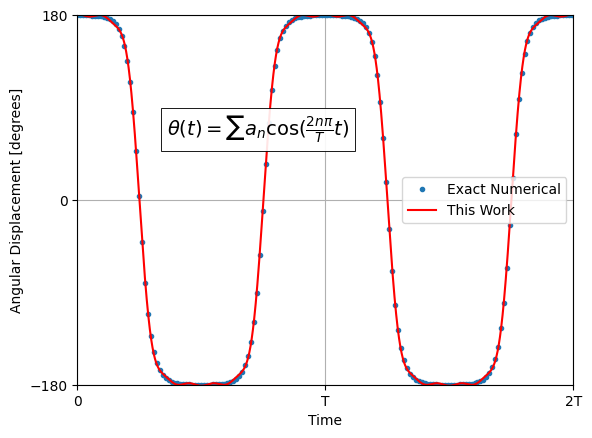

In [9]:
## Checking the expressions in the paper

import numpy as np
import scipy as sp

g = 9.8
L = 9.8

def theta_exact(theta0, t):
    x = np.sin(theta0/2)
    K = sp.special.ellipk(x**2)
    N = len(t)
    theta = np.zeros(N)
    for i in range(N):
        
        [sn, cn, dn, ph] = sp.special.ellipj(np.sqrt(g/L)*t[i] + K, x**2)
        theta[i] = 2*np.arcsin(x*sn)
        
        # alternative form
        #[sn, cn, dn, ph] = sp.special.ellipj(np.sqrt(g/L)*t[i], x**2)
        #theta[i] = 2*np.arcsin(x*cn/dn)

    return theta


def T_ThisWork(theta0):
    n = (np.log(4) - np.log(np.pi))/(np.pi/2 - np.log(4))
    b = np.exp(n*np.pi/2) - 4**n
    T0 = 2*np.pi*np.sqrt(L/g) 
    return T0*2/n/np.pi*np.log( (4/np.cos(theta0/2))**n + b)


def theta_ThisWork(theta0, t):
    
    T = T_ThisWork(theta0)
    kappa = T_ThisWork(np.pi-theta0)/T

    N = len(t)
    theta = np.zeros(N)
    for i in range(N):
        
        sum = 0
        for j in range(1, 10, 2):
            aj = (-1)**((j-1)/2)/j*4/np.cosh(kappa*j*np.pi/2)
            sum = sum + aj*np.cos(2*j*np.pi/T*t[i])
        theta[i] = sum


    return theta

theta0 = 179.9*np.pi/180


T = T_ThisWork(theta0)
print('T [sec] = ', T)

t = np.arange(0,2*T,0.01)
N = len(t)
theta = theta_exact(theta0, t)
theta_ThisWork = theta_ThisWork(theta0, t)

import matplotlib.pyplot as plt

#plt.title('Complete Pendulum Motion for Amplitude $\\theta_0 = 179.9$ deg.')
plt.xlabel('Time')
plt.ylabel('Angular Displacement [degrees]')
plt.xlim([0,2*T])
plt.ylim(-180,180)
plt.xticks([0, T, 2*T], ['0','T', '2T'])
plt.yticks([-180, 0, 180])
plt.plot(t, theta*180/np.pi, '.', markevery=40,label='Exact Numerical')
plt.plot(t, theta_ThisWork*180/np.pi, 'r-', label='This Work')
plt.text(T*0.36,63,'$\\theta(t) = \\sum a_n \\cos(\\frac{2 n \pi}{T} t)$', fontsize=14, \
        bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.7))
plt.legend()
plt.grid()
#plt.savefig('fig3.pdf')
plt.show()

## Derivation the Fourier Solution in Eq. (6)

The equation of motion for a physical pendulum reads

$$\frac{d^2 \theta}{dt^2} + \frac{LMg}{I}\sin \theta = 0\tag{S5}$$

$L$ is the distance from a pivot point to the center of mass. $I$ is the moment of inertia about the pivot point. For a simple pendulum, $I = ML^2$; so the equation of motion reduces to

$$\frac{d^2 \theta}{dt^2} + \frac{g}{L}\sin \theta = 0 \tag{S6}$$

The above form is still inconvenient to work with due to the factor $\frac{g}{L}$ that would have to tag along throughout the derivations. We define a scaled time, 

$$\tau \equiv \sqrt{\frac{g}{L}}t \label{eq_deftime}\tag{S7}$$

so that the equation of motion reduces further to


$$\frac{d^2 \theta}{d\tau^2} + \sin \theta = 0 \label{eq_motion}\tag{S8}$$

Once the solution $\theta(\tau)$ is found, it can be converted back to a function the physical time $\theta(\sqrt{\frac{g}{L}}t)$. If the pendulum is at rest initially with an amplitude $\theta_0$, the solution of Eq. (\ref{eq_motion}) is typically written in the litterature as


$$\theta(\tau) = 2 \arcsin \left[ k \, \text{sn}(\tau+K, k)\right] \label{DLMF_sn_sol}\tag{S9}$$

see [DLMF, 22.19.E2](https://dlmf.nist.gov/22.19.E2). Here, $k = \sin \frac{\theta_0}{2}$. $\text{sn}(z,k)$ is one of the Jacobi elliptic functions; and $K$ is the complete elliptical integral of the first kind, which in this context is a quarter of the period of the pendulum. However, the time dependent can be shifted from the quarter period $K$ back to zero by using the relation

$$\text{sn}(z+K,k) = \text{cd}(z,k)\label{DLMF_sn_cd}\tag{S10}$$

see [DLMF, 22.4.T3](https://dlmf.nist.gov/22.4#T3). $\text{cd}(z,k)$ is another Jacobi elliptic function. Therefore, the solution takes the form

$$\theta(\tau) = 2 \arcsin \left[ k \, \text{cd}(\tau, k)\right] \tag{S11}$$

To avoid the $\arcsin[\cdots]$ dependent above and steering toward a simpler Fourier form, the following integral property is used.

$$\int \text{sd}(x,k) \, dx = -\frac{1}{k k'}\arcsin[  k \, \text{cd}(x, k)] \label{DLMF_int_sd}\tag{S12}  $$

see [DLMF, 22.14.E5](https://dlmf.nist.gov/22.14.E5). Note that the minus sign is taken out of $\arcsin[\cdots]$ function, as compared to the reference. $\text{sd}(z,k)$ is one of the Jacobi elliptic function. Therefore, the solution can now be written as

$$\theta(\tau) = - 2 k k' \int \text{sd}(\tau,k) \, d\tau \label{eq_7}\tag{S13}$$

A fourier expansion of $\text{sd}(z, k)$ is also available. It reads

$$\text{sd}(z,k) = \frac{2\pi}{K k k'}\sum_{n=0}^{\infty} \frac{(-1)^n q^{n+\frac{1}{2}}\sin ((2n+1)\zeta)}{1+q^{2n+1}}  \label{DLMF_sd_fourier}\tag{S14}$$

see [DLMF, 22.11.E5](https://dlmf.nist.gov/22.11.E5). The auxillary variables defined in the reference are: $k' = \sqrt{1-k^2}, q = e^{-\pi K(k')/K(k)}, \zeta = \frac{\pi z}{2K(k)}$. Before going any further, it is convenient to adjust the form of the summation index $n$. Note that $(2n+1)$ is always an odd integer, so we define an odd integer $m = (2n+1)$. The above Fourier expansion becomes

$$\text{sd}(\tau,k) = \frac{2\pi}{K k k'}\sum_{m\,\text{odd}} \frac{(-1)^{\frac{m-1}{2}} q^{\frac{m}{2}}\sin (\frac{m\pi}{2K}\tau)}{1+q^m} = \frac{2\pi}{K k k'}\sum_{m\,\text{odd}} \frac{(-1)^{\frac{m-1}{2}} \sin (\frac{m\pi}{2K}\tau)}{2\cosh(\kappa m \pi/2)}  \tag{S15}$$

Here, we define $\kappa \equiv \frac{T(\pi-\theta_0)}{T(\theta_0)}$. Substutute $\text{sd}(\tau,k)$ above into the integral in Eq. (\ref{eq_7}). The solution becomes


$$\theta(\tau) = -  \frac{2 \pi}{K} \sum_{m\,\text{odd}} \frac{(-1)^{\frac{m-1}{2}} }{\cosh(\kappa m \pi/2)}  \int \sin (\frac{m\pi}{2K}\tau) \, d\tau \tag{S16}$$

Here, the integration is pushed through the summation to meet the time dependent $\sin(\frac{m\pi}{2K}\tau)$. The integration can easily be performed, yielding

$$\theta(\tau) =  \sum_{m\,\text{odd}}   \frac{(-1)^{\frac{m-1}{2}}}{m}  \frac{4}{\cosh(\kappa m \pi /2)}   \cos (\frac{m\pi}{2K}\tau)  \tag{S17}$$

However, $4K$ can be interpreted as the period in the scaled time $\tau$. Therefore, 

$$\cos(\frac{m\pi}{2K}\tau) = \cos(\frac{2 m\pi}{4 K}\tau)\tag{S18}$$

Notice the ratio of the scaled time $\tau$ to its period $4K$. Upon converting from the scaled time to the physical time $\tau \rightarrow \sqrt{\frac{g}{L}} t$, so is the period $4K \rightarrow \sqrt{\frac{g}{L}}T$. Hence, the factor $\sqrt{\frac{g}{L}}$ is eliminated inside the cosine fuctions. Renaming the index $m \rightarrow n$, the final Fouier form as described in the paper is derived.

$$\boxed{\theta(t) =  \sum_{n\,\text{odd}} a_n   \cos (\frac{2 n \pi}{T} t) }  \tag{S19}$$

where the Fourier coefficients (only for n odd) are

$$a_n =   \frac{(-1)^{\frac{n-1}{2}}}{n}  \frac{4}{\cosh(\kappa n \pi /2)},\quad \kappa \equiv \frac{T(\pi-\theta_0)}{T(\theta_0)} \tag{S20}$$

## Generalization: the Phase Constant

The phase constant $\delta$ can be computed by finding a root of 

$$f(\delta) = 0 = \theta_0 - \sum_{n\,\text{odd}} a_n   \cos ( n\delta)\tag{S21} $$

For Newton root finding method, an initial guess of $\delta_0$ need to be given. The successive values of $\delta_n$ can be updated using

$$ \delta_{n+1} = \delta_n - \frac{f(\delta_n)}{f'(\delta_n)} \label{Newton_update}\tag{S22}$$

The iterations stop when the $\delta_n$ converges. The initial guess $\delta_0$ can be determined from using only the first term in the summation, namely.

$$ 0 = \theta_0 - a_1 \cos(\delta_0) \tag{S23}$$

Caution must be taken when solving for $\delta_0$ because there are 2 possible solutions. The two solutions have the same value $\theta_0$, but opposite sign of slope, corresponding to the sign of angular velocity. Depending on the sign of  $\omega_0$,

$$\delta_0  = \begin{cases} \arccos(\theta_0/a_1) & \text{if}\; \omega_0 < 0 \\ 2\pi - \arccos(\theta_0/a_1) & \text{if}\; \omega_0 > 0    \end{cases}\tag{S24}$$

In the python example below, the iterations in Eq. (\ref{Newton_update}) continue until $\delta_{n+1}$ differs from $\delta_n$ smaller than $10^{-8}$. The converged value of $\delta$ is then used to plot $\theta(t)$ and $\omega(t)$.

theta0 [degrees] :  90.0
omega0 [degress/sec] :  81.02840674742424
omega0 must not exceed [degrees/sec]:  81.02846845413956
theta_max [degrees]:  179.89999999999978
delta [degrees]: 279.4028230076408


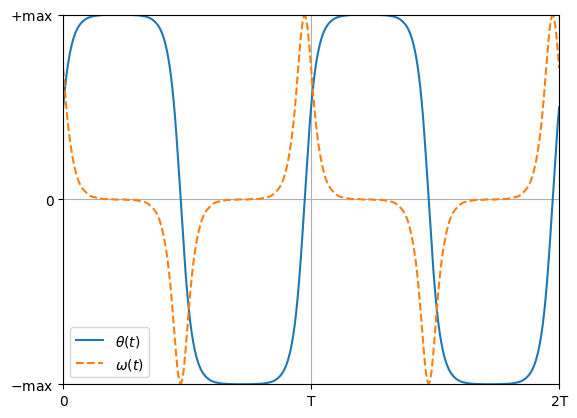

In [10]:
import numpy as np
import matplotlib.pyplot as plt

#
# Choose theta0 and omega0
#

#theta0 = 0
theta0 = 90/180*np.pi
omega0 = np.sqrt( 2*g/L* (np.cos(theta0) - np.cos(179.9/180*np.pi)) )
#omega0 = 0

print('theta0 [degrees] : ', theta0*180/np.pi)
print('omega0 [degress/sec] : ', omega0*180/np.pi)

# check condtion not to flip over at the top
print('omega0 must not exceed [degrees/sec]: ',
      np.sqrt((1+np.cos(theta0))*2*g/L)*180/np.pi )

# compute theta_max
thetamax = np.arccos(np.cos(theta0)-L/g/2*omega0**2)
print('theta_max [degrees]: ', thetamax*180/np.pi)

# compute coefficient an
T = T_ThisWork(thetamax)
kappa = T_ThisWork(np.pi-thetamax)/T

N = 20
a = np.zeros(N)
for j in range(1,N,2):
    a[j] = (-1)**((j-1)/2)/j*4/np.cosh(kappa*j*np.pi/2)

# general angular displacement
def gen_theta(t, delta):

    theta = np.zeros(len(t))
    for i in range(0, len(t)):
        s = 0
        for j in range(1,N,2):
            s = s + a[j]*np.cos(2*j*np.pi*t[i]/T + j*delta)
        theta[i] = s

    return theta

# general angular velocity
def gen_omega(t, delta):

    omega = np.zeros(len(t))
    for i in range(0, len(t)):
        s = 0
        for j in range(1,N,2):
            s = s - 2*j*np.pi/T * a[j]*np.sin(2*j*np.pi*t[i]/T + j*delta)
        omega[i] = s

    return omega


# compute phase shift delta using newton method
def phase_shift(theta0, cutoff):
    
    def f(delta):
        sum = 0
        for j in range(1,N,2):
            sum = sum + a[j]*np.cos(j*delta)
        return theta0 - sum

    def fp(delta):
        sum = 0
        for j in range(1,N,2):
            sum = sum - j*a[j]*np.sin(j*delta)
        return -sum

    # initial guess
    if omega0 == 0.0: return 0.0
    delta = np.arccos(theta0/a[1])
    if omega0 > 0: delta = 2*np.pi - delta
    
    # update
    while True:
        step = - f(delta)/fp(delta)
        delta = delta + step
        if np.abs(step) < cutoff: break
            
    return delta

delta = phase_shift(theta0, 1e-8)
print('delta [degrees]:', delta*180/np.pi)

t = np.arange(0,2*T,0.01)
theta = gen_theta(t, delta)
omega = gen_omega(t, delta)

#compute amplitude of angular velocity (conservation of energy)
# 1/2 ML^2 omega0^2 - M g L cos(theta0) = 1/2 ML^2 omegamax^2 - M g L
omegamax = np.sqrt(omega0**2 - 2*g/L*np.cos(theta0) + 2*g/L)

#plt.title('General angular displacement and velocity')
plt.plot(t, theta/np.abs(thetamax), label='$\\theta(t)$')
plt.plot(t, omega/np.abs(omegamax),'--', label='$\\omega(t)$')
plt.xlim(0,2*T)
plt.ylim(-1,+1)
plt.xticks([0,T,2*T],['0','T','2T'])
plt.yticks([-1,0,1],['$-$max','0','$+$max'])
plt.grid()
plt.legend()
#plt.savefig('fig4.pdf')
plt.show()

## References

Ganley, W. P. (1985). Simple pendulum approximation. American Journal of Physics, 53(1), 73–76. https://doi.org/10.1119/1.13970

Lima, F. M. S. (2008). Simple ‘log formulae’ for pendulum motion valid for any amplitude. European Journal of Physics, 29(5), 1091–1098. https://doi.org/10.1088/0143-0807/29/5/021

[DLMF]  NIST Digital Library of Mathematical Functions. https://dlmf.nist.gov/, Release 1.2.4 of 2025-03-15. F. W. J. Olver, A. B. Olde Daalhuis, D. W. Lozier, B. I. Schneider, R. F. Boisvert, C. W. Clark, B. R. Miller, B. V. Saunders, H. S. Cohl, and M. A. McClain, eds.